In [1]:
import keras
import numpy as np
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# 34 features (with mass-sculpting ones)
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau21',
            'fj_tau32',
            'fj_sdsj1_mult',
            'fj_sdsj1_mass',
            'fj_sdsj2_mult',
            'fj_sdsj2_mass',
            'fj_n_sdsubjets',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

label_names = ['truthQCD', 
               'truthHbb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [3]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        mask = (spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)
        feature_array = feature_array[mask]
        label_array = label_array[mask]
        spec_array = spec_array[mask]

    mask = np.sum(label_array,axis=1)==1
    feature_array = feature_array[mask]
    label_array = label_array[mask]
    spec_array = spec_array[mask]

    h5file.close()
    return feature_array, label_array, spec_array

In [4]:
# copy training file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_10.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array, spec_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

In [5]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

W0919 21:09:09.057026 4563711424 deprecation_wrapper.py:119] From /Users/jduarte/miniconda3/envs/keras-training/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 21:09:09.129199 4563711424 deprecation_wrapper.py:119] From /Users/jduarte/miniconda3/envs/keras-training/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 21:09:09.130017 4563711424 deprecation_wrapper.py:119] From /Users/jduarte/miniconda3/envs/keras-training/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0919 21:09:09.144122 4563711424 deprecation_wrapper.py:119] From /Users/jduarte/miniconda3/envs/keras-training/lib/python3.6/site-packages/keras/backend/tensorflow

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 34)                0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 34)                136       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2240      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 5,578
Trainable params: 5,510
Non-trainable params: 68
_________________________________________________________________
None


In [6]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=10, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

W0919 21:09:09.272994 4563711424 deprecation.py:323] From /Users/jduarte/miniconda3/envs/keras-training/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 150255 samples, validate on 37564 samples
Epoch 1/10
150255/150255 [==============================] - 2s 13us/step - loss: 0.2321 - acc: 0.9135 - val_loss: 0.1770 - val_acc: 0.9318
Epoch 2/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1698 - acc: 0.9346 - val_loss: 0.1650 - val_acc: 0.9363
Epoch 3/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1604 - acc: 0.9379 - val_loss: 0.1584 - val_acc: 0.9393
Epoch 4/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1549 - acc: 0.9403 - val_loss: 0.1541 - val_acc: 0.9408
Epoch 5/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1512 - acc: 0.9414 - val_loss: 0.1516 - val_acc: 0.9418
Epoch 6/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1486 - acc: 0.9422 - val_loss: 0.1498 - val_acc: 0.9424
Epoch 7/10
150255/150255 [==============================] - 1s 6us/step - loss: 0.1466 - acc: 0.9433 - val_loss: 0.1483 

In [7]:
# copy testing file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_0.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .
        
# load testing file
feature_array_test, label_array_test, spec_array_test = get_features_labels('ntuple_merged_0.h5')

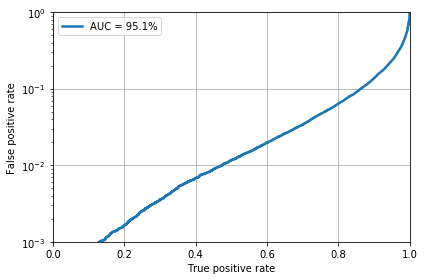

In [8]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)
# run model inference on training data set
predict_array = keras_model.predict(feature_array)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])

fpr_train, tpr_traim, threshold_train = roc_curve(label_array[:,1], predict_array[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')

In [9]:

FPR_cut = 0.001


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]
idx, val = find_nearest(fpr_train,FPR_cut)
threshold_val = threshold_train[idx]

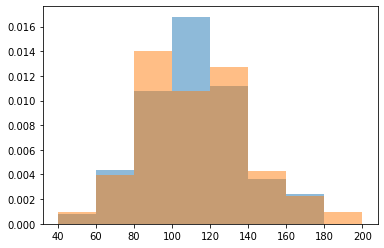

In [10]:
import scipy
import pandas as pd

predict_names = ['predictQCD','predictHbb']
frame = pd.DataFrame(np.hstack([feature_array_test,
                                label_array_test,
                                spec_array_test,
                                predict_array_test]), 
                     columns = features+label_names+spectators+predict_names)

train_frame = pd.DataFrame(np.hstack([feature_array,
                                label_array,
                                spec_array,
                                predict_array]), 
                     columns = features+label_names+spectators+predict_names)

plt.figure()
plt.hist(frame['fj_sdmass'], weights = frame['truthQCD']*(frame['predictHbb']>threshold_val), 
         bins=np.linspace(40,200,8+1),alpha=0.5,density=True)
plt.hist(train_frame['fj_sdmass'], weights = train_frame['truthQCD']*(train_frame['predictHbb']>threshold_val), 
         bins=np.linspace(40,200,8+1),alpha=0.5,density=True)
plt.show()

Fitting Quantile Reg. of FPR = 0.001
      Iter       Train Loss   Remaining Time 
         1         886.1757           17.05s
         2         863.0134           14.85s
         3         843.3581           14.23s
         4         822.7620           14.83s
         5         804.9247           14.95s
         6         788.0758           15.12s
         7         774.0569           15.26s
         8         761.3887           15.38s
         9         750.6868           15.41s
        10         739.7898           15.52s
        20         676.6607           15.41s
        30         657.7395           14.81s


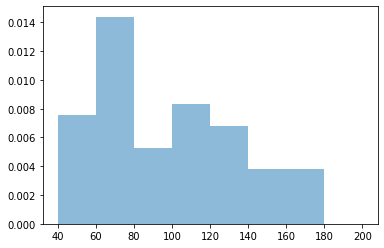

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

def quantile_regression_DDT(dfs, dfs_train, FPR_cut): 
        
    print('Fitting Quantile Reg. of FPR = ' + str(FPR_cut))
    data_train = [[mass, pT] for mass, pT in zip(dfs_train.loc[dfs_train['truthQCD'] == 1]['fj_sdmass'].values , dfs_train.loc[dfs_train['truthQCD'] == 1]['fj_pt'].values)]
    data = [[mass, pT] for mass, pT in zip(dfs['fj_sdmass'].values , dfs['fj_pt'].values)]
    
    if FPR_cut > 0.1:
        aux_scale = 0.1*float(FPR_cut)/3000.
        
    else: 
        aux_scale = 0.1*float(FPR_cut)/100.
            
    model = GradientBoostingRegressor(loss='quantile', alpha= 1 - float(FPR_cut), 
                                          n_estimators=250, 
                                          min_samples_leaf=3, min_samples_split=3, 
                                          max_depth=5, 
                                          validation_fraction=0.2, 
                                          n_iter_no_change=5, tol=1e-4, 
                                          verbose=1)
    model.fit(data_train, dfs_train.loc[dfs_train['truthQCD'] == 1]['predictHbb'].values/aux_scale)
        
    cuts = aux_scale*model.predict(data)
    return cuts

frame['predictHbbDDT'] = frame['predictHbb'] - quantile_regression_DDT(frame,train_frame,FPR_cut)

plt.figure()
plt.hist(frame['fj_sdmass'], weights = frame['truthQCD']*(frame['predictHbbDDT']>0), 
         bins=np.linspace(40,200,8+1),alpha=0.5,density=True)
plt.show()

In [12]:
def get_jsd_limit(frame=[], epsilonB=0.01):   
    ndatapoints = 100
        
    mmin = 40
    mmax = 200
    nbins = 8
        
    frame = frame.loc[frame['truthQCD'] == 1]
    N = len(frame)
    nB = N*epsilonB
        
    kld = []
    for i in range(ndatapoints): 
        nB_exp = np.random.poisson(nB)
            
        index_b = np.random.choice(int(N), int(nB_exp),replace=False)
        index_a = np.delete(range(N), index_b)
            
        frame_a = frame.iloc[index_a]
        frame_b = frame.iloc[index_b] 
            
        mass_a = frame_a['fj_sdmass'].values
        mass_b = frame_b['fj_sdmass'].values

        # digitize into bins
        spec_pass = np.digitize(mass_a, bins=np.linspace(mmin,mmax,nbins+1), right=False)-1
        spec_fail = np.digitize(mass_b, bins=np.linspace(mmin,mmax,nbins+1), right=False)-1
            
        # one hot encoding
        spec_ohe_pass = np.zeros((spec_pass.shape[0],nbins))
        spec_ohe_pass[np.arange(spec_pass.shape[0]),spec_pass] = 1
        spec_ohe_pass_sum = np.sum(spec_ohe_pass,axis=0)/spec_ohe_pass.shape[0]
        spec_ohe_fail = np.zeros((spec_fail.shape[0],nbins))
        spec_ohe_fail[np.arange(spec_fail.shape[0]),spec_fail] = 1
        spec_ohe_fail_sum = np.sum(spec_ohe_fail,axis=0)/spec_ohe_fail.shape[0]
        M = 0.5*spec_ohe_pass_sum+0.5*spec_ohe_fail_sum
        kld_pass = scipy.stats.entropy(spec_ohe_pass_sum,M,base=2)
        kld_fail = scipy.stats.entropy(spec_ohe_fail_sum,M,base=2)
        jsd = 0.5*kld_pass+0.5*kld_fail

        kld.append(1./jsd)      

    return(np.mean(kld), np.std(kld))
    
def get_jsd(frame=[], epsilonB=0.01, var = 'predictHbbDDT'):   

        mmin = 40
        mmax = 200
        nbins = 8
        
        frame = frame.loc[frame['truthQCD'] == 1]
                
        if var=='predictHbbDDT':
            threshold_val = 0
        else:   
            idx, val = find_nearest(fpr_train,epsilonB)
            # FIX THRESHOLD VALUE, FPR DEPENDING ON VARIABLE TYPE!
            threshold_val = threshold_train[idx]
            
            
        frame_a = frame[frame[str(var)]>threshold_val]
        frame_b = frame[frame[str(var)]<threshold_val]
            
        mass_a = frame_a['fj_sdmass'].values
        mass_b = frame_b['fj_sdmass'].values

        # digitize into bins
        spec_pass = np.digitize(mass_a, bins=np.linspace(mmin,mmax,nbins+1), right=False)-1
        spec_fail = np.digitize(mass_b, bins=np.linspace(mmin,mmax,nbins+1), right=False)-1
            
        # one hot encoding
        spec_ohe_pass = np.zeros((spec_pass.shape[0],nbins))
        spec_ohe_pass[np.arange(spec_pass.shape[0]),spec_pass] = 1
        spec_ohe_pass_sum = np.sum(spec_ohe_pass,axis=0)/spec_ohe_pass.shape[0]
        spec_ohe_fail = np.zeros((spec_fail.shape[0],nbins))
        spec_ohe_fail[np.arange(spec_fail.shape[0]),spec_fail] = 1
        spec_ohe_fail_sum = np.sum(spec_ohe_fail,axis=0)/spec_ohe_fail.shape[0]
        M = 0.5*spec_ohe_pass_sum+0.5*spec_ohe_fail_sum
        kld_pass = scipy.stats.entropy(spec_ohe_pass_sum,M,base=2)
        kld_fail = scipy.stats.entropy(spec_ohe_fail_sum,M,base=2)
        jsd = 0.5*kld_pass+0.5*kld_fail

        return(1./jsd)
    
print(get_jsd_limit(frame, epsilonB=FPR_cut))
print(get_jsd(frame, epsilonB=FPR_cut, var = 'predictHbb'))
print(get_jsd(frame, epsilonB=FPR_cut, var = 'predictHbbDDT'))

(45.78822052251856, 38.09783607050967)
5.7130238636575035
20.835263810591528
